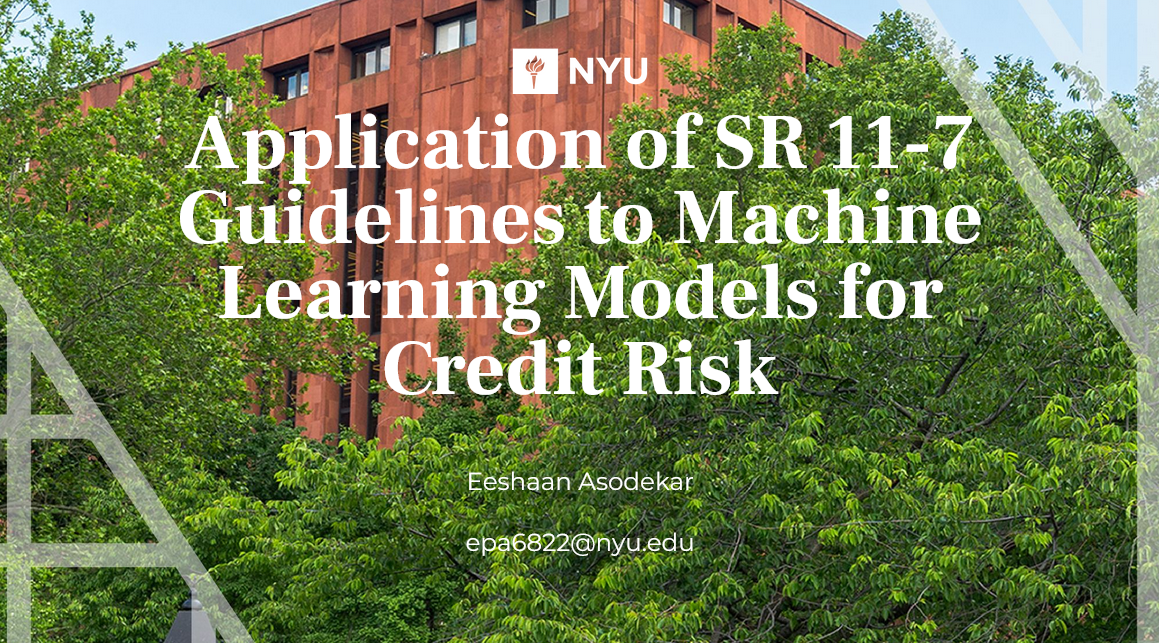

The purpose of this project is to develop, and validate an interpretable and proven machine learning approaches for the prediction of credit card default which algin with the supervisory guidance given in SR 11-7.

This project (as of the current version) is broken into these sections:
1. Model Developement

2. Model Validation

Extensive EDA and Feature Engineering will be performed in later versions of the project.

#Model Developement

##Subsection 1: Dataset Quality Assessment

Let us start of by assessing the quality of the TaiwanCredit credit card dataset.

Link: https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

In [ ]:
# # installing PiML for later use
# !pip install piml

In [1]:
# for the TiwanCredit dataset
!pip install ucimlrepo

###(A) Downloading data from UC Irvine Machine Learning Repository

In [2]:
from ucimlrepo import fetch_ucirepo

# fetching dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

# Splitting into response and target varibles
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

In [3]:
# metadata
print(default_of_credit_card_clients.metadata)

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'title': 'The comparisons of data mining techniques for the predictive accuracy of probability of default of cre

In [4]:
# variable information
print(default_of_credit_card_clients.variables)

   name     role     type      demographic                 description units  \
0    ID       ID  Integer             None                        None  None   
1    X1  Feature  Integer             None                   LIMIT_BAL  None   
2    X2  Feature  Integer              Sex                         SEX  None   
3    X3  Feature  Integer  Education Level                   EDUCATION  None   
4    X4  Feature  Integer   Marital Status                    MARRIAGE  None   
5    X5  Feature  Integer              Age                         AGE  None   
6    X6  Feature  Integer             None                       PAY_0  None   
7    X7  Feature  Integer             None                       PAY_2  None   
8    X8  Feature  Integer             None                       PAY_3  None   
9    X9  Feature  Integer             None                       PAY_4  None   
10  X10  Feature  Integer             None                       PAY_5  None   
11  X11  Feature  Integer             No

In [5]:
# snapshot of the features
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [6]:
# snapshot of the target
y.head()

,Y
0,1
1,1
2,0
3,0
4,0


###(B) Checking for missing values and duplicates

In [7]:
print("Number of total missing values in the X df: ",X.isnull().sum().sum())

Number of total missing values in the X df:  0


In [8]:
print("Number of duplicate observations in X df: ",X.duplicated().sum())

Number of duplicate observations in X df:  56


In [9]:
print("Number of total missing values in the y df: ",y.isnull().sum().sum())

Number of total missing values in the y df:  0


In [10]:
y.shape

(30000, 1)

In [11]:
# for ease of data wrangling and feature engineering, let us combine the two dataframes
# Combining DataFrames with outer join (keeps all rows); can do this since there are no NaNs
df = X.join(y)

In [12]:
df.shape
# length same as X and y

(30000, 24)

In [13]:
# Dropping duplicate rows
df = df.drop_duplicates()

In [14]:
df.shape

(29965, 24)

In [15]:
df.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'Y'],
      dtype='object')

###(C) Checking the imbalance of the dataset

In [16]:
sum(df['Y']==0)/df.shape[0]

0.7787418655097614

In [17]:
sum(df['Y']==1)/df.shape[0]

0.22125813449023862

Only about 20% of the dataset has target Y = 1 (i.e. the customer defaulted).

We will need to handle this imblance in the dataset before model training. Some algorithms my be robust to imbalanced dataset, but we must now be alert for high accruacy and high fnr%.

###(D) Identifying and handling outliers

We must weed out the outliers from our training dataset.

This is done because although there are ML algorithms (e.g. Random Forest) which are less sensitive to outliers, we want to explore the use of more complex algorithms which are senstive to outliers (e.g. XGBoost). Also, we want the model selection process to be fair to all models.

We are using the IQR approach to tag an instance as an outlier or not.



In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def remove_outliers(df):
    # We are not going to apply IQR to these columns
    # These columns are Gender, Education, Maritial Status, and Age
    exclude_columns = ['X2', 'X3', 'X4', 'X5', 'Y']

    # Identifying columns where IQR will be applied
    iqr_columns = [col for col in df.columns if col not in exclude_columns]

    # Calculating Q1, Q3 and IQR for all the relevant columns
    Q1 = df[iqr_columns].quantile(0.25)
    Q3 = df[iqr_columns].quantile(0.75)
    IQR = Q3 - Q1

    # Defining outliers as any value outside 1.5 * IQR from Q1 or Q3
    outliers_condition = ((df[iqr_columns] < (Q1 - 1.5 * IQR)) | (df[iqr_columns] > (Q3 + 1.5 * IQR)))

    # Finding index of rows with outliers
    outlier_indices = df[outliers_condition.any(axis=1)].index

    # Visualizing original data
    plt.figure(figsize=(20, 10))
    plt.suptitle('Original Data Distributions with Outliers', fontsize=16)
    for i, col in enumerate(iqr_columns):
        plt.subplot(4, 5, i + 1)
        sns.boxplot(x=df[col])
        plt.title(col)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Removing outliers
    df_clean = df.drop(index=outlier_indices)

    # Visualizing cleaned data
    plt.figure(figsize=(20, 10))
    plt.suptitle('Data Distributions After Removing Outliers', fontsize=16)
    for i, col in enumerate(iqr_columns):
        plt.subplot(4, 5, i + 1)
        sns.boxplot(x=df_clean[col])
        plt.title(col)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return df_clean

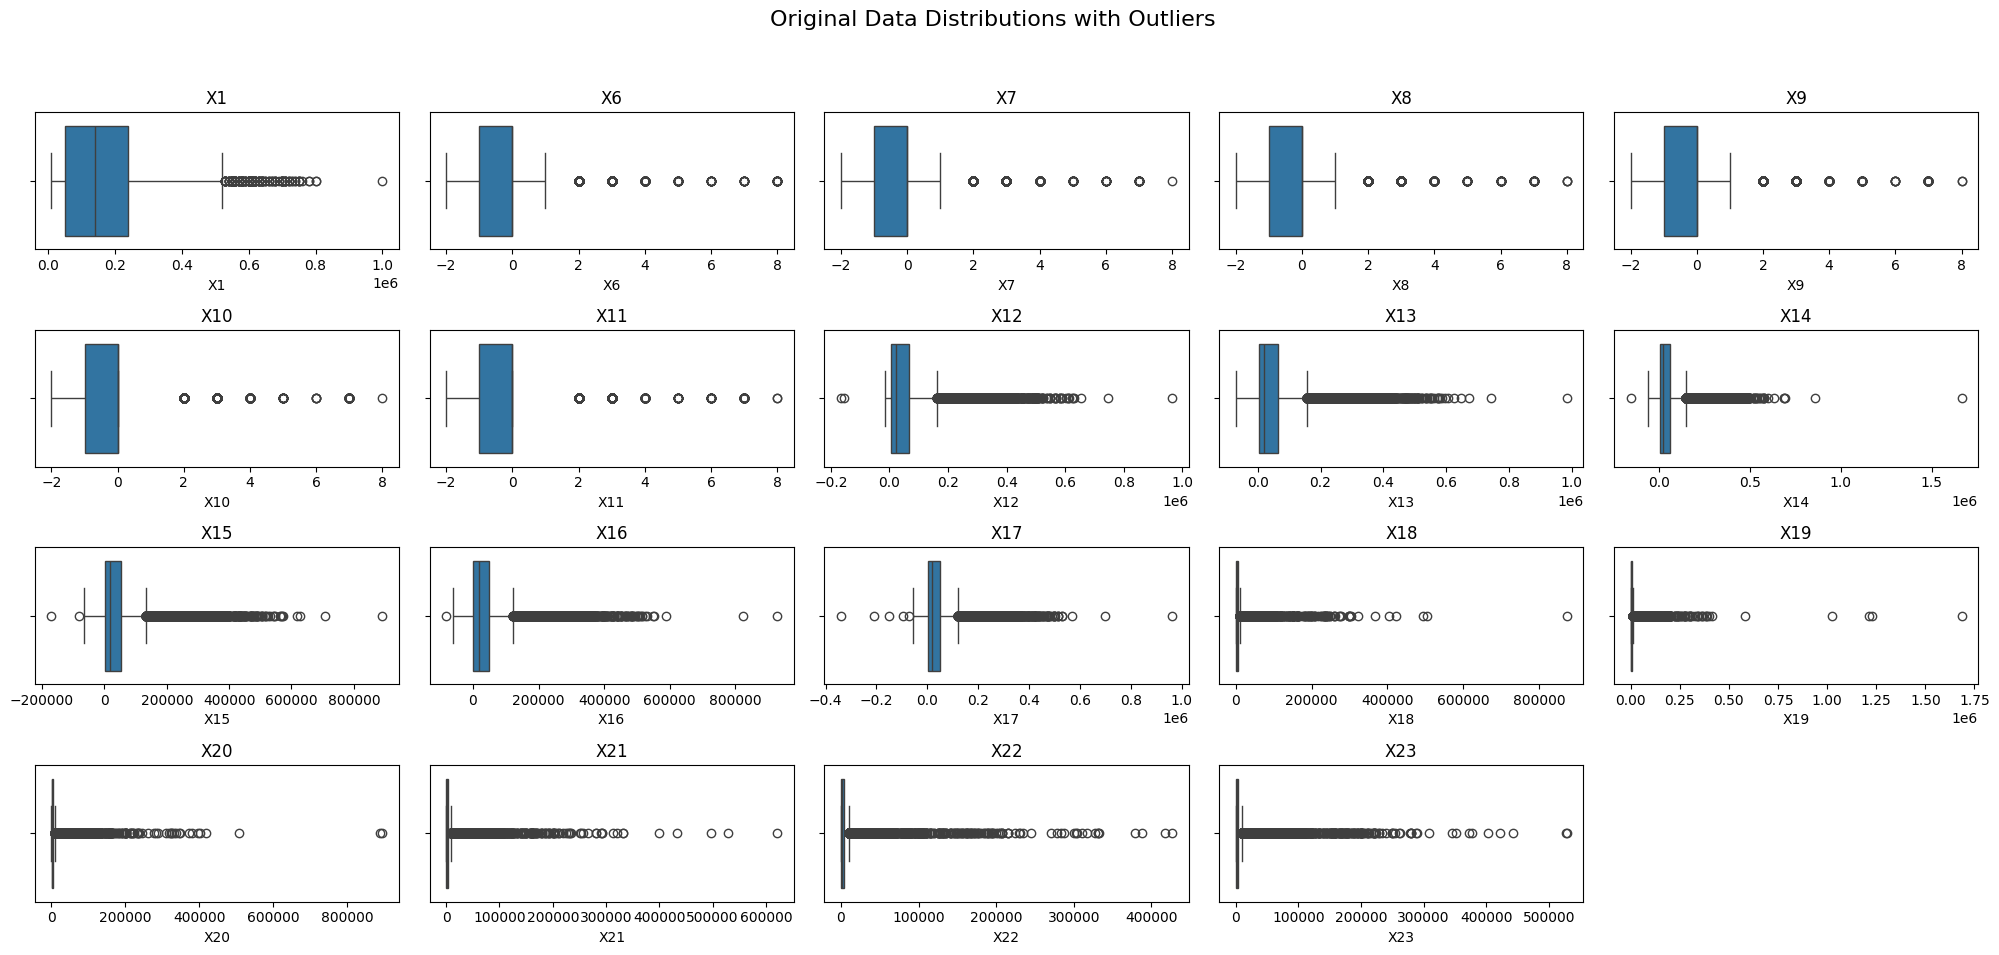

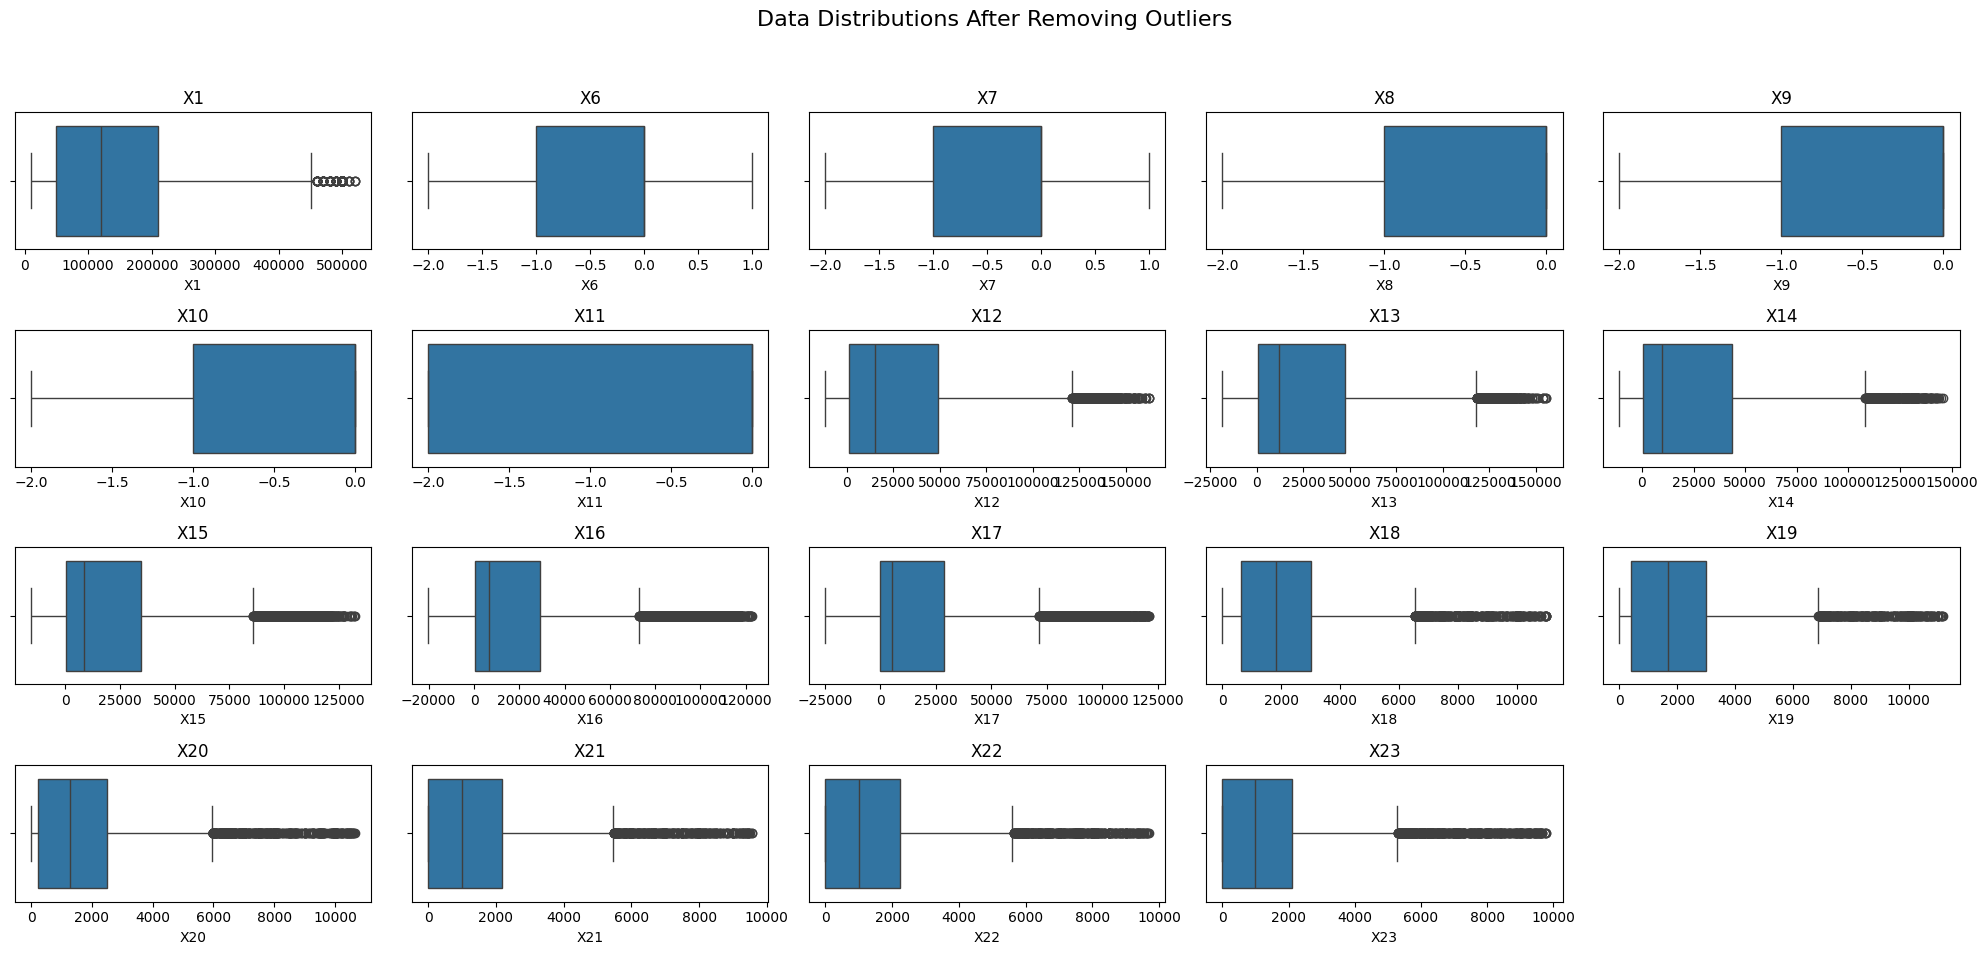

In [19]:
df_clean = remove_outliers(df)

In [20]:
df.shape

(29965, 24)

In [21]:
df.isnull().sum().sum()

0

In [22]:
df_clean.shape

(13229, 24)

In [23]:
df_clean.isnull().sum().sum()

0

We can see that the tradtional method of data cleaning is not going to work.

This is because most of the defaults will have huge bill amounts or amounts outstanding; removing those data points will make the dataset even more imbalanced.

Using this approach reduces the dataset from 30k instances to 13k instances; with only about 1.5k instances having Y=1.

We might want to use the same set of models on both the datasets and compare the test set performance for when models are training on the (1) untouched dataset (2) outlier cleaned dataset.

For this version, let us stick to the untouched dataset (which contains outliers), and let us explore training on the cleaned dataset in the later versions.

##Subsection 2: Feature Engineering - Data Augmentation

Let us do some basic feature engineering. Let us condense the transaction data into a few features.

###(A) Debt-to-Credit Ratio
Idea: Create a feature that represents the ratio of the bill amount to the credit limit. This will provide a sense of how much of the credit line the customer is utilizing, which is a strong indicator of credit risk.

In [24]:
# Debt-to-Credit Ratio
for month in range(12, 18):  # X12 to X17
    df[f'Debt-to-Credit Ratio_{month}'] = df[f'X{month}'] / df['X1']

###(B) Average Delay in Payments
Idea: Calculate the average delay in payments over the last six months. This feature would summarize the payment history into a single metric, reflecting the customer's recent payment behavior.

In [25]:
# Average Delay in Payments
df['Average Delay'] = df[['X6', 'X7', 'X8', 'X9', 'X10', 'X11']].clip(lower=0).mean(axis=1)

In [26]:
df.isnull().sum().sum()

0

###(C) Change in Bill Amount
Idea: Calculate the month-to-month percentage change in bill amount to capture trends in spending behavior.

In [27]:
# Adjusted Change in Bill Amount Calculation
for month in range(13, 18):  # X13 to X17, X12 has no previous month in the data
    prev_month = month - 1
    # Calculate change only where the previous month's bill amount is not zero
    df[f'Change in Bill Amount_{month}'] = np.where(
        df[f'X{prev_month}'] != 0,
        (df[f'X{month}'] - df[f'X{prev_month}']) / df[f'X{prev_month}'] * 100,
        np.where(
            (df[f'X{prev_month}'] == 0) & (df[f'X{month}'] == 0),
            0,  # No change if both are zero
            100  # Assume a 100% increase if previous is zero but current is not
        )
    )

In [28]:
df.shape

(29965, 36)

In [29]:
df.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'Y', 'Debt-to-Credit Ratio_12', 'Debt-to-Credit Ratio_13',
       'Debt-to-Credit Ratio_14', 'Debt-to-Credit Ratio_15',
       'Debt-to-Credit Ratio_16', 'Debt-to-Credit Ratio_17', 'Average Delay',
       'Change in Bill Amount_13', 'Change in Bill Amount_14',
       'Change in Bill Amount_15', 'Change in Bill Amount_16',
       'Change in Bill Amount_17'],
      dtype='object')

In [30]:
df.isnull().sum().sum()

0

##Subsection 3: Model Search and Final Model selection

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

###(A) Train Test Split

In [32]:
# let us now split the data into the input features and response variable
# for now, we use using the dataset which has not been outlier cleaned
X = df.drop(['X2','X3','X4','X5','Y',], axis=1) # dropping the personal data and response variable
y = df['Y']

# 80:20 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

For this version of the project, let us limit our model search to SVM, RF, and XGBoost. These models are simple to understand and interpret, yet provide significant outperformance. From my interaction with industry professions I learnt that XGboost and Random Forest have been widely used in banks for mortgage approaval, credit card default modelling etc.

In [33]:
def kfoldcrossvalidation_compare(X_train,y_train):
    # Model list to evaluate
    models = {
        "SVM": SVC(probability=True, random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }

    # Setup of cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Results storage
    results = {name: {'AUC': [], 'Accuracy': [], 'False Positive Rate': [], 'False Negative Rate': []} for name in models}

    # Perform k-fold cross-validation and collect metric scores
    for name, model in models.items():
        for train_index, test_index in kf.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            # Fit the model to current fold
            model.fit(X_train_fold, y_train_fold)

            if hasattr(model, "predict_proba"):
                y_pred_proba = model.predict_proba(X_test_fold)[:, 1]
            else:
                y_pred_proba = model.decision_function(X_test_fold)
            y_pred = model.predict(X_test_fold)

            # Calculating metrics: AUC, ACC, FPR%, FNR% for current fold
            auc = roc_auc_score(y_test_fold, y_pred_proba)
            accuracy = accuracy_score(y_test_fold, y_pred)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, y_pred).ravel()
            fpr = fp / (fp + tn)
            fnr = fn / (fn + tp)


            results[name]['AUC'].append(auc)
            results[name]['Accuracy'].append(accuracy)
            results[name]['False Positive Rate'].append(fpr)
            results[name]['False Negative Rate'].append(fnr)

    # Printing and plotting results in terms of a bar graph
    # for each metric and each model
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    fig.suptitle('Comparison of Model Performance Metrics')

    metrics = ['AUC', 'Accuracy', 'False Positive Rate', 'False Negative Rate']
    for ax, metric in zip(axes.flatten(), metrics):
        sns.boxplot(data={name: model_results[metric] for name, model_results in results.items()}, ax=ax)
        ax.set_title(metric)
        ax.set_ylabel('Score')
        ax.set_xlabel('Models')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

###(B) K fold cross validation - unscaled data with outliers

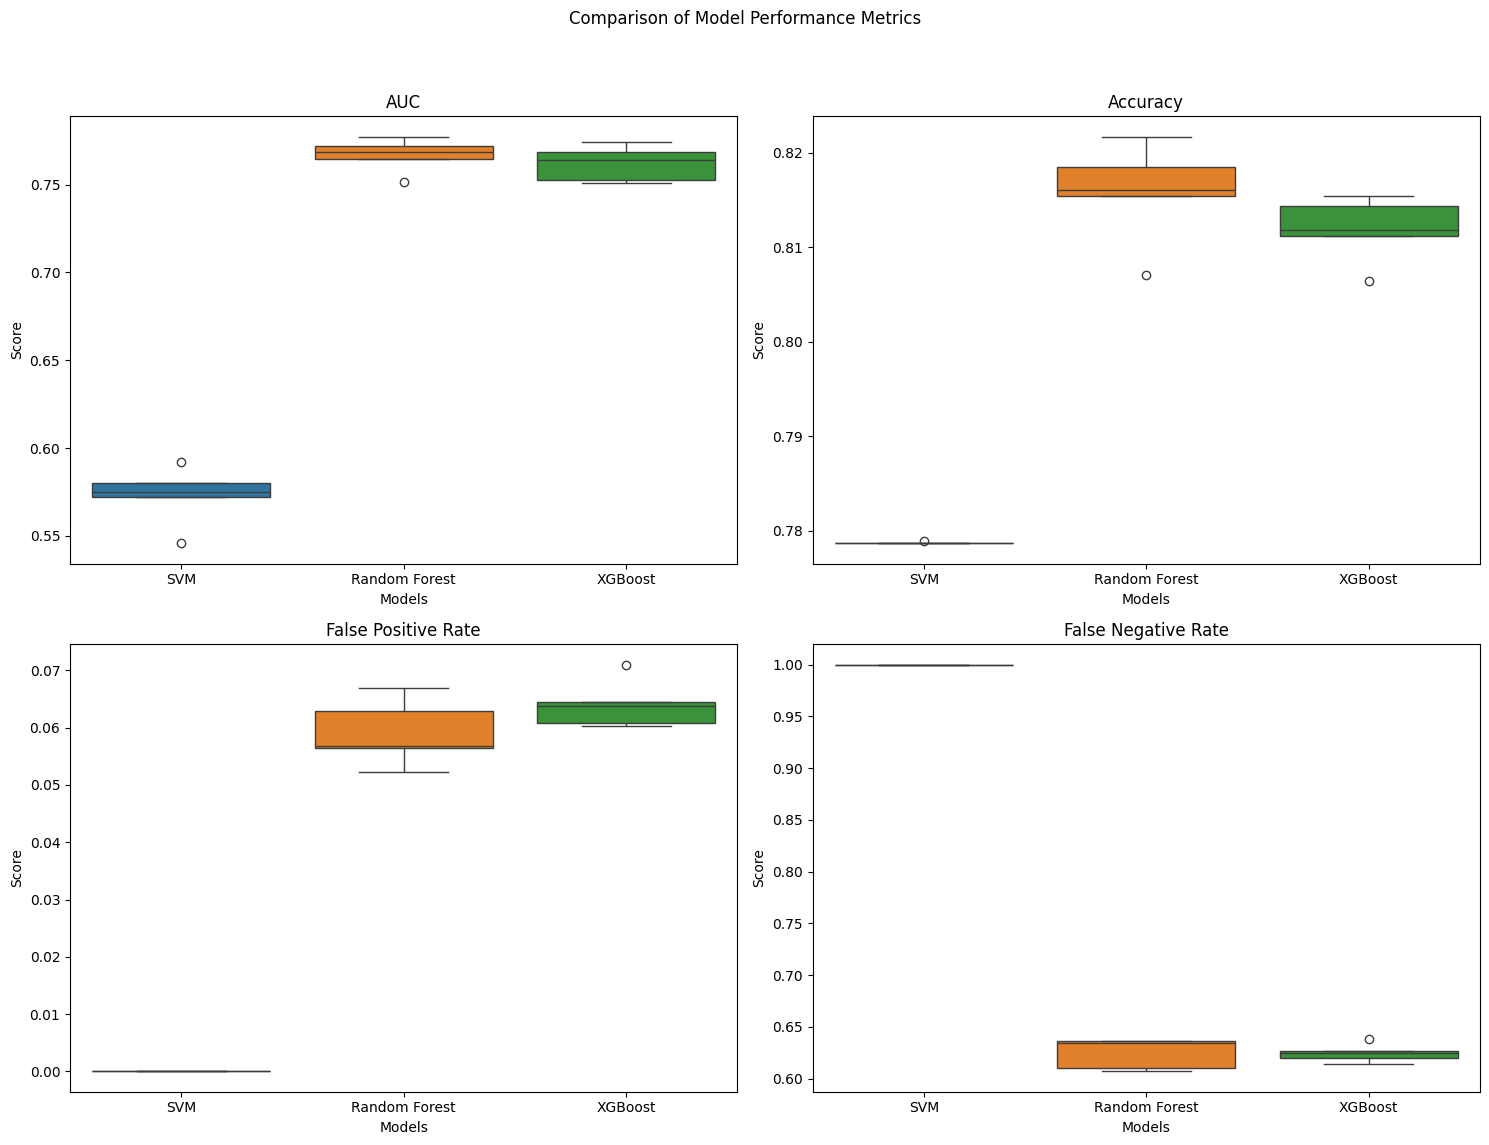

In [ ]:
kfoldcrossvalidation_compare(X_train,y_train)

We can see that although all the models perform poorly, SVM suffers the worst since it cannot work very well with unscaled data.

###(C) K fold cross validation - scaled data (StandardScaler) with outliers

In [34]:
# Applying standardization to the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# converting it back into a df to give as input to our kfold cross validation fucntion
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

X_test_scaled = scaler.transform(X_test)
# converting back to df
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

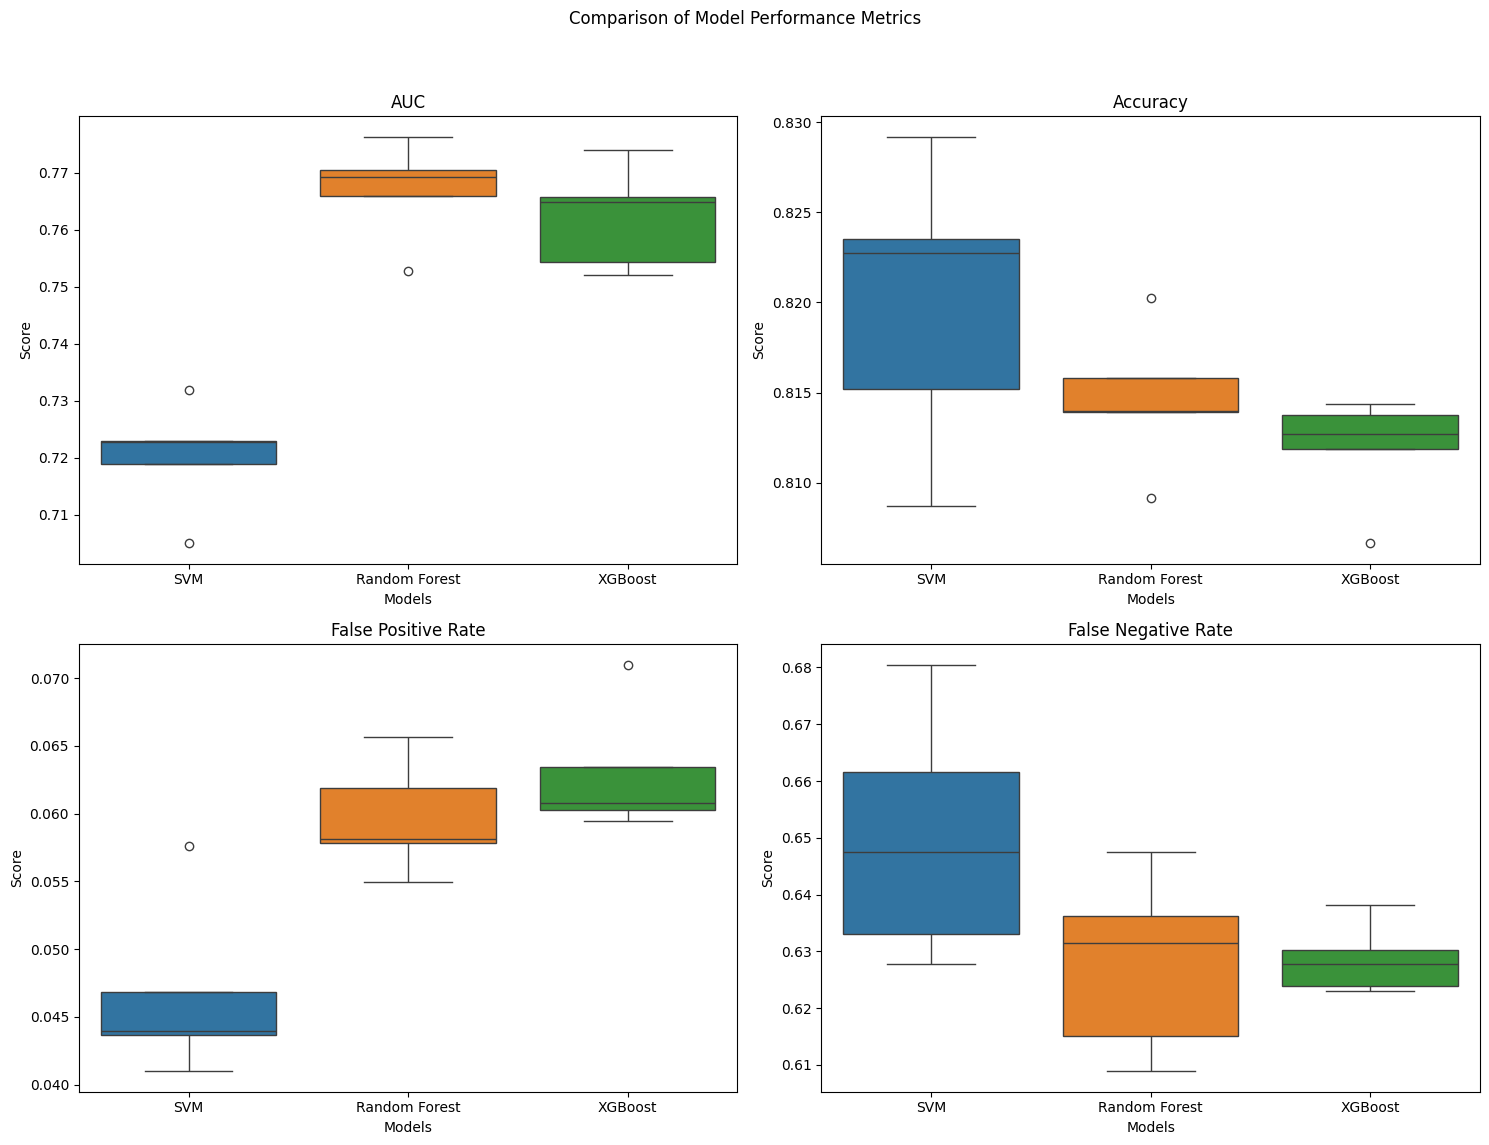

In [ ]:
kfoldcrossvalidation_compare(X_train_scaled,y_train)

We can see significant improvement in the SVM performance, and negligible improvement from RF and XGBoost.

We see that Although the accuracy is high, the FNR% (predicting non-defults for actual default instances) is very high. This aligns with our expectations in Subsection 1 (C).

Let us explore resampling techniques to address this issue and give a more balanced training dataset to the model.

###(D) K fold cross validation - SMOTE and Scaled Data

In [35]:
# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_scaled_smote, y_train_scaled_smote = smote.fit_resample(X_train_scaled, y_train)

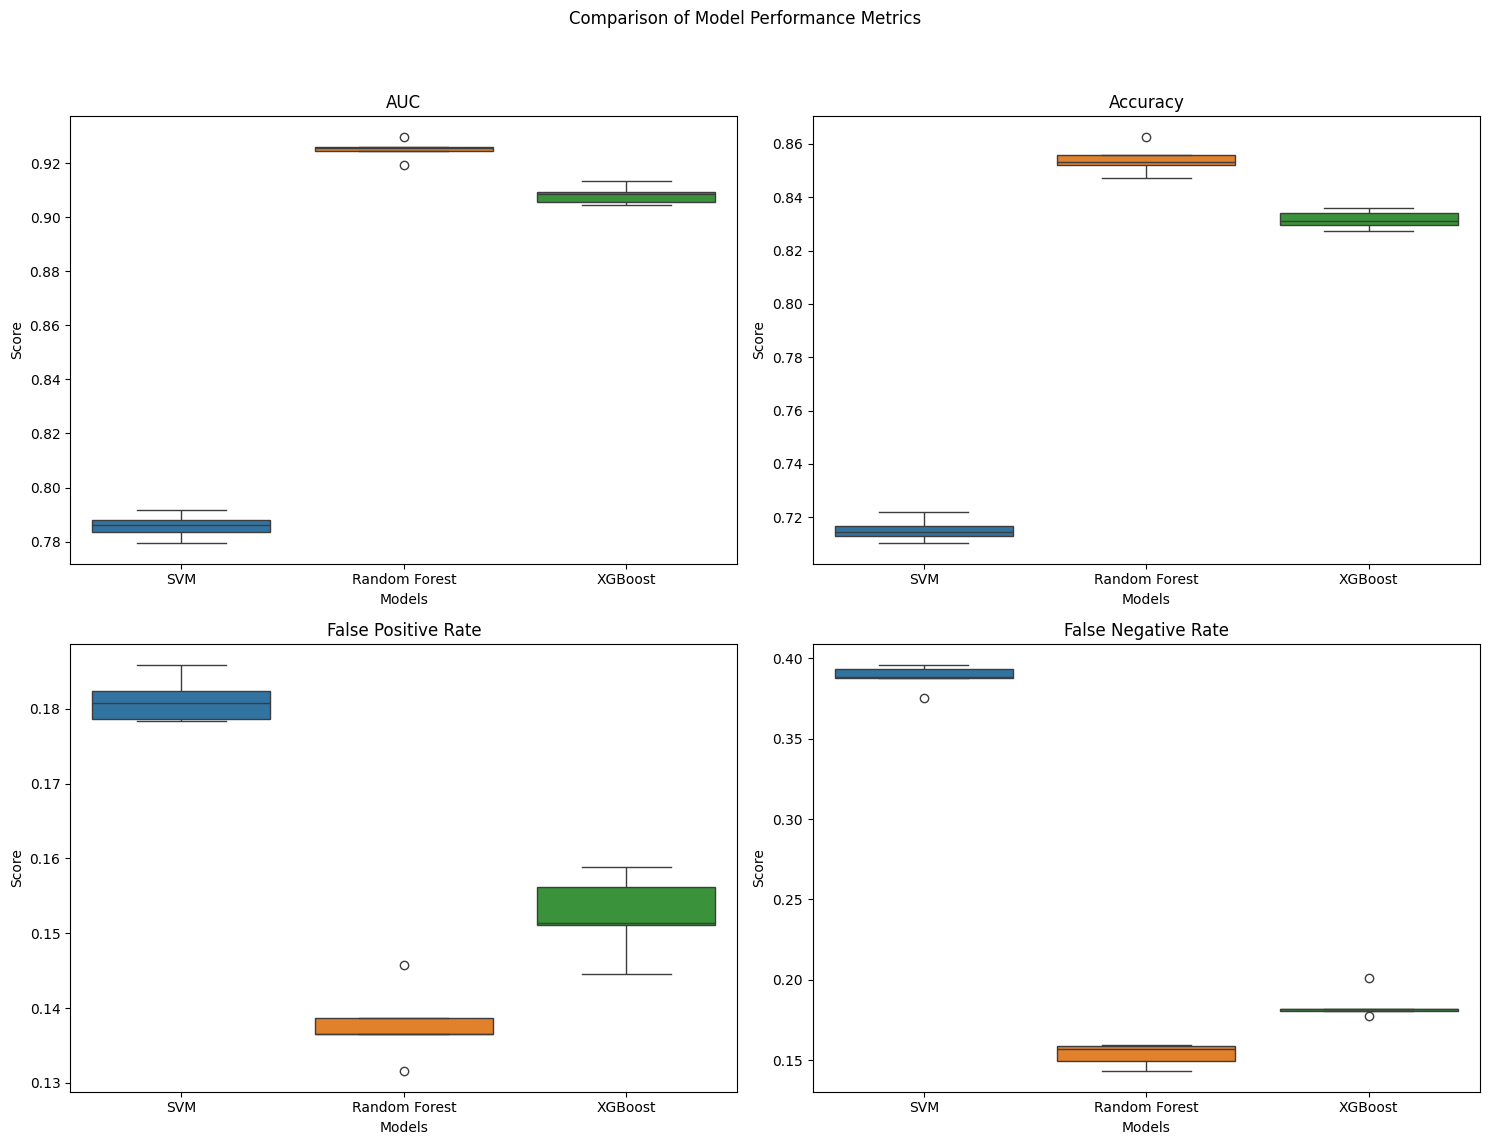

In [ ]:
kfoldcrossvalidation_compare(X_train_scaled_smote,y_train_scaled_smote)

###(E) K fold cross validation - ADASYN and Scaled Data

Why ADASYN: choosing ADASYN over SMOTE could be particularly effective in our scenario due to its adaptive nature, which focuses on generating synthetic data for harder-to-classify instances, potentially reducing our high false negative rate.

In [36]:
from imblearn.over_sampling import ADASYN
# applying ADASYN to balance the dataset
adasyn = ADASYN(random_state=42)
X_train_scaled_adasyn, y_train_scaled_adasyn = adasyn.fit_resample(X_train_scaled, y_train)

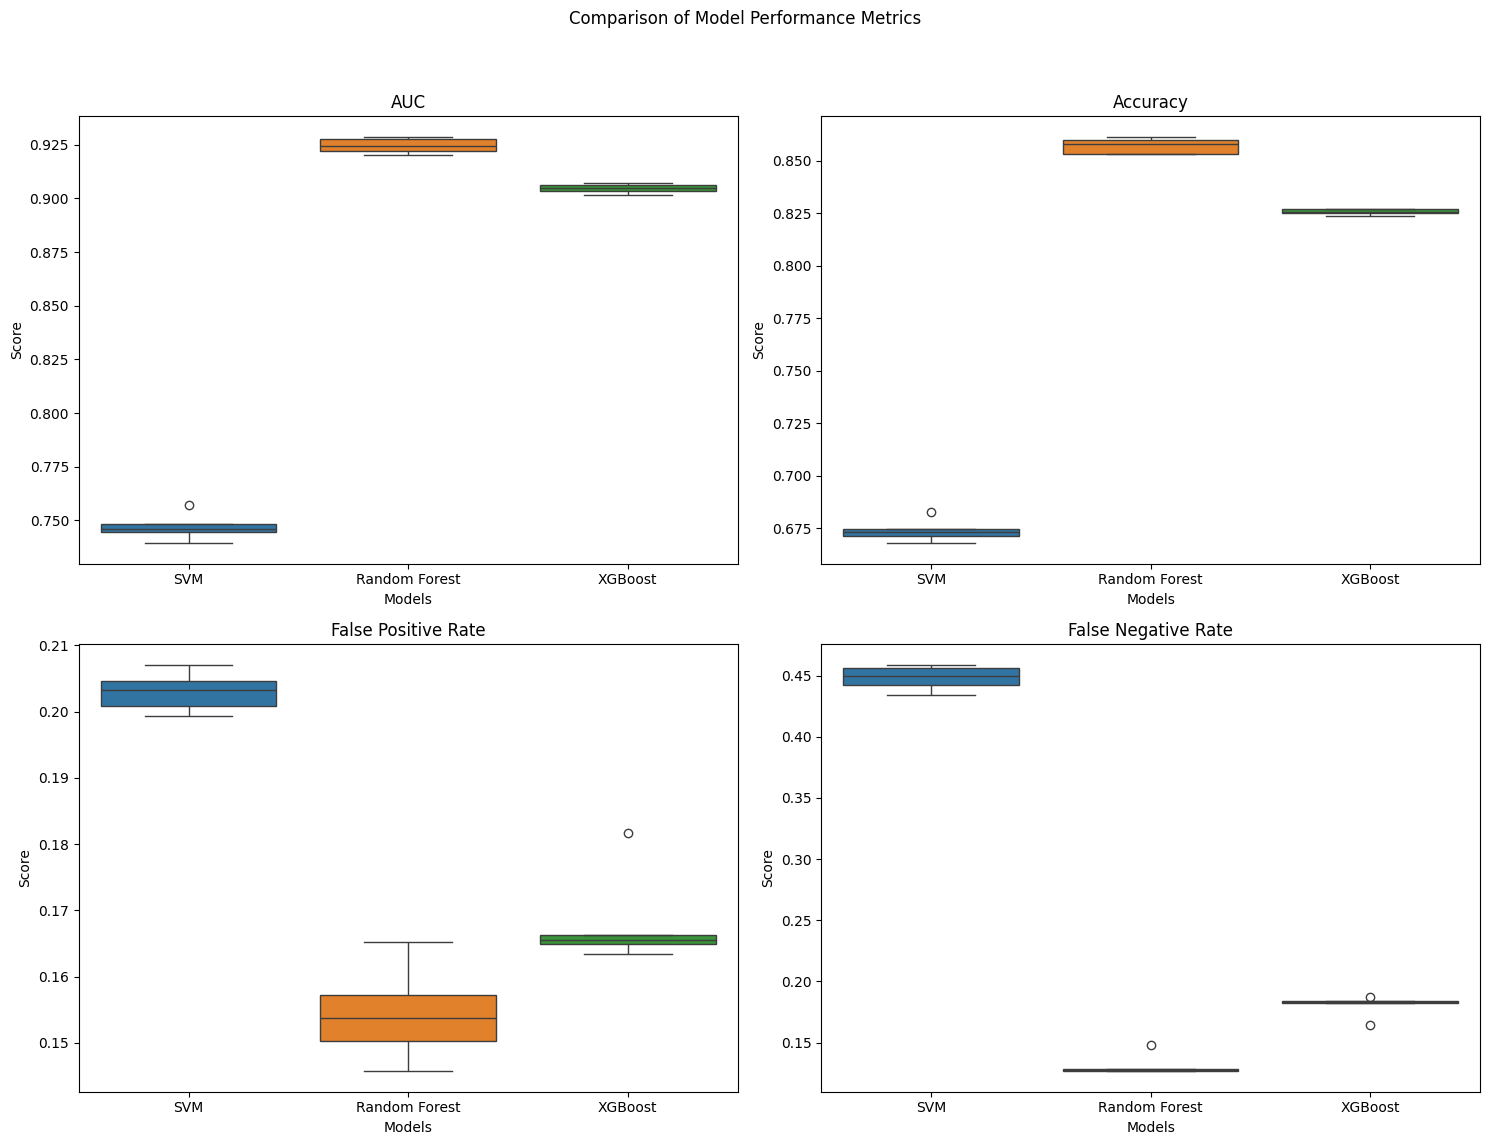

In [ ]:
kfoldcrossvalidation_compare(X_train_scaled_adasyn,y_train_scaled_adasyn)

##Subsection 4: Model Tuning and Testing

We can see that the Random Forest approach clearly outperforms the XGBoost approach (and the SVM approach).

Apart from the higher AUC and ACC as compared to XGBoost, it has a lower FNR% whcich is critical to this area of application.

Let us now perform hyperparameter tuning for this approach.

###(A) Random Forest hyperparamter grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# A limited parameter grid for Random Forest
# more extensive grid search would be conducted in later versions
param_grid_rf = {
    'n_estimators': [100, 500,1000,3000],
    'max_depth': [3, 10],
    'min_samples_split': [2, 10]
}

model_rf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, scoring='roc_auc', cv=5)

# Performing grid search
grid_rf_result = grid_rf.fit(X_train_scaled_adasyn, y_train_scaled_adasyn)

print("Random Forest Best: %f using %s" % (grid_rf_result.best_score_, grid_rf_result.best_params_))

output obtained: Random Forest Best: 0.859437 using {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 1000}



###(B) RF Tuned model training and testing

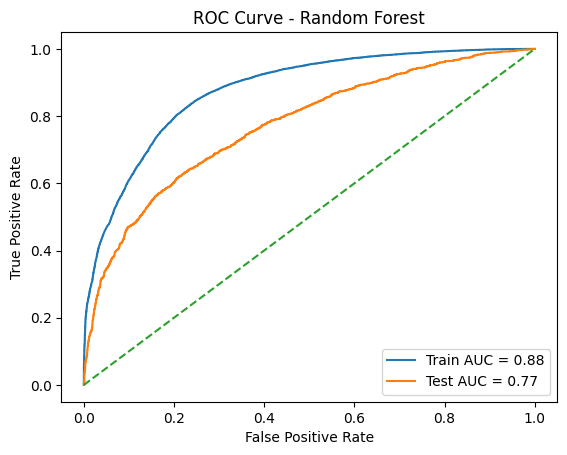

Training Data:
Accuracy: 0.7931, AUC: 0.8768, False Positive Rate: 0.1797, False Negative Rate: 0.2339
Testing Data:
Accuracy: 0.7449, AUC: 0.7719, False Positive Rate: 0.2224, False Negative Rate: 0.3703


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Initializing the tuned Random Forest model
model_tuned_rf = RandomForestClassifier(
    max_depth=10,
    min_samples_split=2,
    n_estimators=1000,
    random_state=42,
    class_weight='balanced'
)

# Fit the model on the balanced and scaled training data
model_tuned_rf.fit(X_train_scaled_adasyn, y_train_scaled_adasyn)

# Make predictions on training data
y_train_pred_rf = model_tuned_rf.predict(X_train_scaled_adasyn)
y_train_proba_rf = model_tuned_rf.predict_proba(X_train_scaled_adasyn)[:, 1]

# Make predictions on test data
y_test_pred_rf = model_tuned_rf.predict(X_test_scaled)
y_test_proba_rf = model_tuned_rf.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for training and test data
train_accuracy_rf = accuracy_score(y_train_scaled_adasyn, y_train_pred_rf)
train_auc_rf = roc_auc_score(y_train_scaled_adasyn, y_train_proba_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
test_auc_rf = roc_auc_score(y_test, y_test_proba_rf)

tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_train_scaled_adasyn, y_train_pred_rf).ravel()
train_fpr_rf = fp_rf / (fp_rf + tn_rf)
train_fnr_rf = fn_rf / (fn_rf + tp_rf)

tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_test, y_test_pred_rf).ravel()
test_fpr_rf = fp_rf / (fp_rf + tn_rf)
test_fnr_rf = fn_rf / (fn_rf + tp_rf)

# Plot ROC curve for train and test
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train_scaled_adasyn, y_train_proba_rf)
fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_test_proba_rf)
roc_auc_train_rf = auc(fpr_train_rf, tpr_train_rf)
roc_auc_test_rf = auc(fpr_test_rf, tpr_test_rf)

plt.figure()
plt.plot(fpr_train_rf, tpr_train_rf, label=f'Train AUC = {roc_auc_train_rf:.2f}')
plt.plot(fpr_test_rf, tpr_test_rf, label=f'Test AUC = {roc_auc_test_rf:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

# Print out the AUC, ACC< FNR%, FPR% metrics
print("Training Data:")
print(f"Accuracy: {train_accuracy_rf:.4f}, AUC: {train_auc_rf:.4f}, False Positive Rate: {train_fpr_rf:.4f}, False Negative Rate: {train_fnr_rf:.4f}")
print("Testing Data:")
print(f"Accuracy: {test_accuracy_rf:.4f}, AUC: {test_auc_rf:.4f}, False Positive Rate: {test_fpr_rf:.4f}, False Negative Rate: {test_fnr_rf:.4f}")

#Model Validation

##Subsection 1: Quantiative Validation

###(A) Benchmarking: RF Tuned model v/s Logistic Regression


- Baseline Performance:
  
  Logistic Regression is a well-established and well-understood model.
  
  If RandomForest performs significantly better than Logistic Regression, it provides evidence that the more complex model is capturing more complex patterns

- Feature Importance comparison:
  
  We can compare and contrast the feature importance
  
  A radical shift would indicate insidious logical error in the RandomForest approach


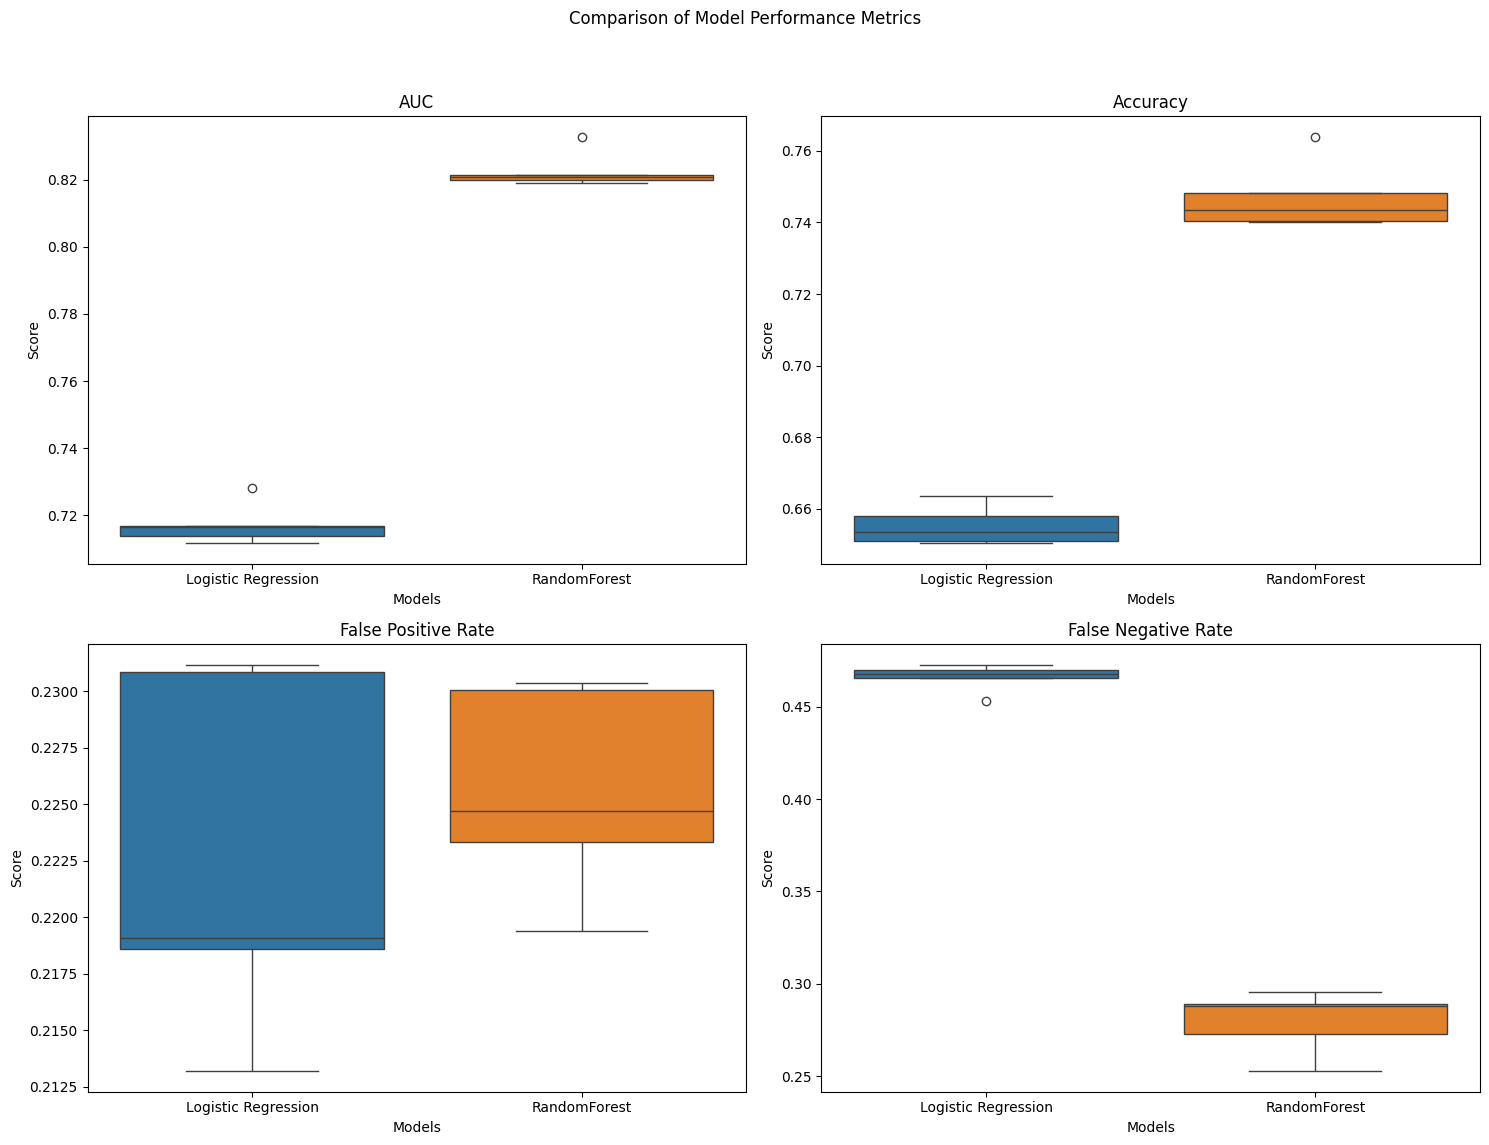

In [43]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Models to evaluate
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "RandomForest": RandomForestClassifier(
    max_depth=10,
    min_samples_split=2,
    n_estimators=1000,
    random_state=42,
    class_weight='balanced')
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Prepare results storage
results = {name: {'AUC': [], 'Accuracy': [], 'False Positive Rate': [], 'False Negative Rate': []} for name in models}

# Perform k-fold cross-validation and collect metric scores
for name, model in models.items():
    for train_index, test_index in kf.split(X_train_scaled_adasyn, y_train_scaled_adasyn):
        X_train_fold, X_test_fold = X_train_scaled_adasyn.iloc[train_index], X_train_scaled_adasyn.iloc[test_index]
        y_train_fold, y_test_fold = y_train_scaled_adasyn.iloc[train_index], y_train_scaled_adasyn.iloc[test_index]  # Use .iloc for correct indexing

        # Fit the model
        model.fit(X_train_fold, y_train_fold)

        # Predict probabilities and labels
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test_fold)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test_fold)
        y_pred = model.predict(X_test_fold)

        # Calculate metrics
        auc = roc_auc_score(y_test_fold, y_pred_proba)
        accuracy = accuracy_score(y_test_fold, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test_fold, y_pred).ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)

        results[name]['AUC'].append(auc)
        results[name]['Accuracy'].append(accuracy)
        results[name]['False Positive Rate'].append(fpr)
        results[name]['False Negative Rate'].append(fnr)

# Print results and plot them
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
fig.suptitle('Comparison of Model Performance Metrics')

metrics = ['AUC', 'Accuracy', 'False Positive Rate', 'False Negative Rate']
for ax, metric in zip(axes.flatten(), metrics):
    sns.boxplot(data={name: model_results[metric] for name, model_results in results.items()}, ax=ax)
    ax.set_title(metric)
    ax.set_ylabel('Score')
    ax.set_xlabel('Models')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

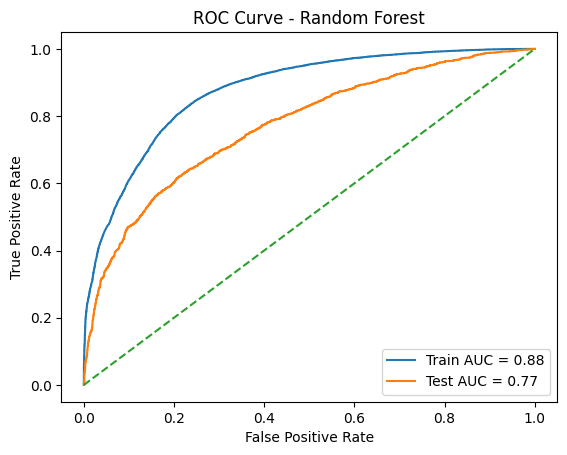

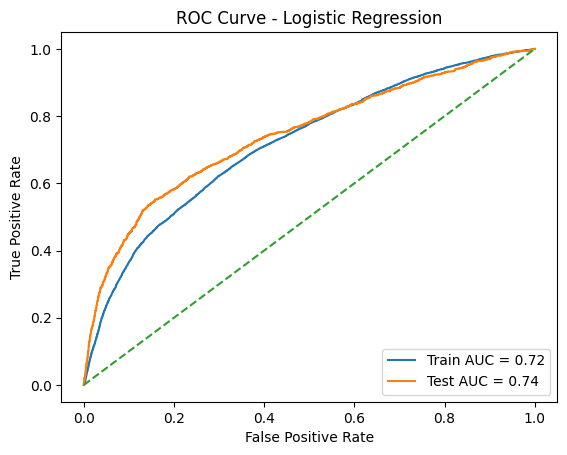

Random Forest - Training Data:
Accuracy: 0.7931, AUC: 0.8768, False Positive Rate: 0.1797, False Negative Rate: 0.2339
Random Forest - Testing Data:
Accuracy: 0.7449, AUC: 0.7719, False Positive Rate: 0.2224, False Negative Rate: 0.3703
Logistic Regression - Training Data:
Accuracy: 0.6555, AUC: 0.7186, False Positive Rate: 0.2214, False Negative Rate: 0.4666
Logistic Regression - Testing Data:
Accuracy: 0.7409, AUC: 0.7433, False Positive Rate: 0.2198, False Negative Rate: 0.3974


In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(
        max_depth=10,
        min_samples_split=2,
        n_estimators=1000,
        random_state=42,
        class_weight='balanced'
    ),
    "Logistic Regression": LogisticRegression(
        random_state=42,
    )
}

# Fit models and evaluate
results = {}
for model_name, model in models.items():
    model.fit(X_train_scaled_adasyn, y_train_scaled_adasyn)

    # Make predictions on training data
    y_train_pred = model.predict(X_train_scaled_adasyn)
    y_train_proba = model.predict_proba(X_train_scaled_adasyn)[:, 1]

    # Make predictions on test data
    y_test_pred = model.predict(X_test_scaled)
    y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics for training and test data
    train_accuracy = accuracy_score(y_train_scaled_adasyn, y_train_pred)
    train_auc = roc_auc_score(y_train_scaled_adasyn, y_train_proba)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)

    tn, fp, fn, tp = confusion_matrix(y_train_scaled_adasyn, y_train_pred).ravel()
    train_fpr = fp / (fp + tn)
    train_fnr = fn / (fn + tp)

    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    test_fpr = fp / (fp + tn)
    test_fnr = fn / (fn + tp)

    # Plot ROC curve for train and test
    fpr_train, tpr_train, _ = roc_curve(y_train_scaled_adasyn, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Train AUC = {roc_auc_train:.2f}')
    plt.plot(fpr_test, tpr_test, label=f'Test AUC = {roc_auc_test:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Store results
    results[model_name] = {
        "Train Accuracy": train_accuracy,
        "Train AUC": train_auc,
        "Train FPR": train_fpr,
        "Train FNR": train_fnr,
        "Test Accuracy": test_accuracy,
        "Test AUC": test_auc,
        "Test FPR": test_fpr,
        "Test FNR": test_fnr
    }

# Print results
for model_name, metrics in results.items():
    print(f"{model_name} - Training Data:")
    print(f"Accuracy: {metrics['Train Accuracy']:.4f}, AUC: {metrics['Train AUC']:.4f}, False Positive Rate: {metrics['Train FPR']:.4f}, False Negative Rate: {metrics['Train FNR']:.4f}")
    print(f"{model_name} - Testing Data:")
    print(f"Accuracy: {metrics['Test Accuracy']:.4f}, AUC: {metrics['Test AUC']:.4f}, False Positive Rate: {metrics['Test FPR']:.4f}, False Negative Rate: {metrics['Test FNR']:.4f}")


We can see that the Random Forest outperforms the benchmark Logistic Regression model, not only on the AUC and ACC metric, but more importantly on the FNR%.

###(B) Senstivity Analysis

Let us purturb the top 2 most weighted features to see if the performance metrics move significantly for proposed model and the benchmark model.

In [52]:
i= 0
for column in X_train_scaled_adasyn.columns:
  print(i," ",column)
  i+=1

0   X1
1   X6
2   X7
3   X8
4   X9
5   X10
6   X11
7   X12
8   X13
9   X14
10   X15
11   X16
12   X17
13   X18
14   X19
15   X20
16   X21
17   X22
18   X23
19   Debt-to-Credit Ratio_12
20   Debt-to-Credit Ratio_13
21   Debt-to-Credit Ratio_14
22   Debt-to-Credit Ratio_15
23   Debt-to-Credit Ratio_16
24   Debt-to-Credit Ratio_17
25   Average Delay
26   Change in Bill Amount_13
27   Change in Bill Amount_14
28   Change in Bill Amount_15
29   Change in Bill Amount_16
30   Change in Bill Amount_17


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Models to evaluate
# Our tuned Random Forest, Logistic Regression, as well as XGBoost
models = {
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        colsample_bytree=0.8,
        learning_rate=0.01,
        max_depth=3,
        n_estimators=1000,
        subsample=0.5
    ),
    "Random Forest": RandomForestClassifier(
        max_depth=10,
        min_samples_split=2,
        n_estimators=1000,
        random_state=42,
        class_weight='balanced'
    ),
    "Logistic Regression": LogisticRegression(
        random_state=42,
    )
}

# Fit models on training data
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Function to perturb feature and evaluate model performance
def perturb_feature_and_evaluate(model, X, y, feature_index, perturbation_factor):
    X_perturbed = np.array(X, copy=True)
    X_perturbed[:, feature_index] *= (1 + perturbation_factor)
    y_pred = model.predict(X_perturbed)
    y_proba = model.predict_proba(X_perturbed)[:, 1]
    accuracy = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_proba)
    return accuracy, auc_score

# Indices for 'Average Delay' and 'X6'
average_delay_index = 25
x6_index = 1

# Perturbation factors
perturbations = [-0.03, 0.03]  # -3% and +3% perturbation

# Test sensitivity to feature perturbations
features = {
    'Average Delay': average_delay_index,
    'X6': x6_index
}

results = {model_name: {} for model_name in models}

for model_name, model in models.items():
    for feature_name, index in features.items():
        results[model_name][feature_name] = {}
        for perturbation in perturbations:
            description = f"{int(perturbation * 100)}%"
            train_accuracy, train_auc = perturb_feature_and_evaluate(model, X_train_scaled_adasyn, y_train_scaled_adasyn, index, perturbation)
            test_accuracy, test_auc = perturb_feature_and_evaluate(model, X_test_scaled, y_test, index, perturbation)
            results[model_name][feature_name][description] = {
                'Train Accuracy': train_accuracy,
                'Train AUC': train_auc,
                'Test Accuracy': test_accuracy,
                'Test AUC': test_auc
            }

# Output the results
from pprint import pprint
pprint(results)

We can clearly see that Logistic regression performs significantly worse than the tuned Random Forest model in terms of its sensitivty to the top two features.

For logistic regression, the test AUC drops from ~70% to ~60% when the top two features are purturbed by +/- 10%, whereas the selected Random Forest model experiences lesser negative impact of the purturbation.

###(C) Feature importance analysis

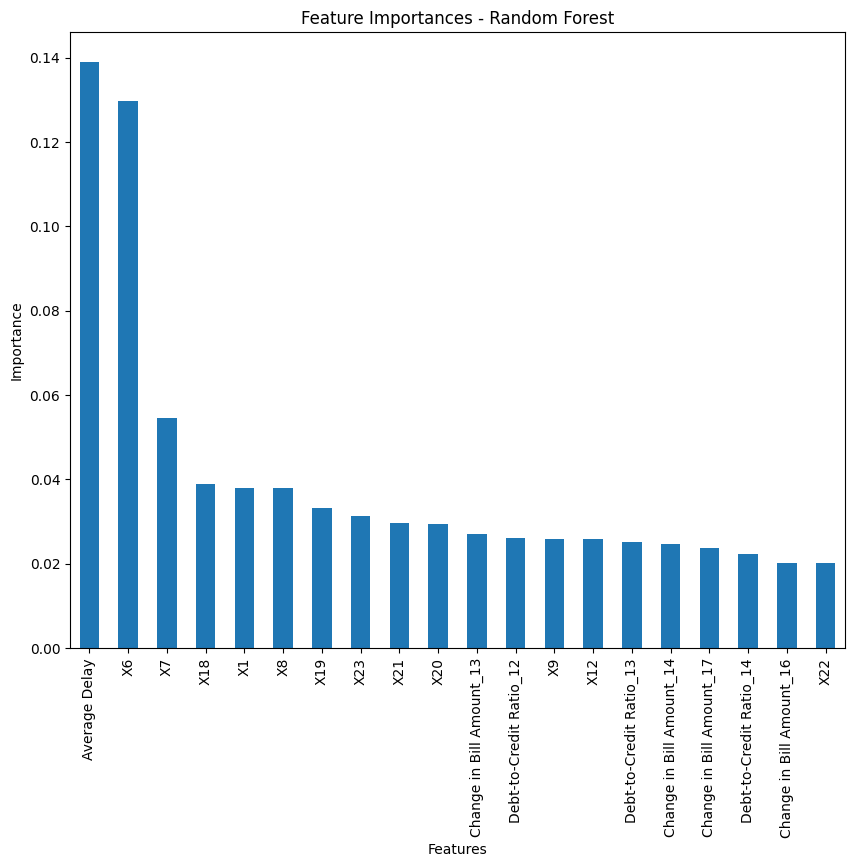

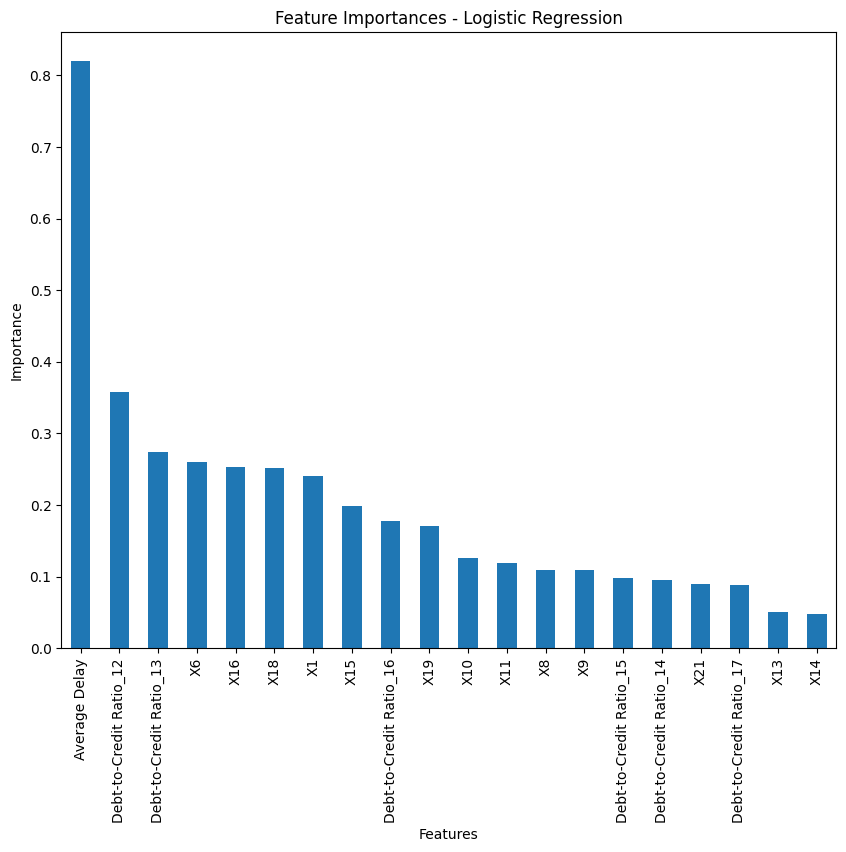

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc

# Initializing models
models = {
    "Random Forest": RandomForestClassifier(
        max_depth=10,
        min_samples_split=2,
        n_estimators=1000,
        random_state=42,
        class_weight='balanced'
    ),
    "Logistic Regression": LogisticRegression(
        random_state=42,
        max_iter=1000
    )
}

# Dictionary to store feature importances
feature_importances = {}

# Fit models and evaluate
for model_name, model in models.items():
    model.fit(X_train_scaled_adasyn, y_train_scaled_adasyn)

    # Extract feature importances
    if model_name == "Random Forest":
        importances = model.feature_importances_
    elif model_name == "Logistic Regression":
        # For logistic regression, the importance can be considered as the absolute value of the coefficients
        importances = np.abs(model.coef_[0])

    feature_importances[model_name] = importances

    # Plotting feature importances
    feature_importance_series = pd.Series(importances, index=X_train_scaled_adasyn.columns)
    sorted_importances = feature_importance_series.sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    sorted_importances[:20].plot(kind='bar')  # Visualizing top 20 features
    plt.title(f'Feature Importances - {model_name}')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.show()
